# Quant Trading Project
## By: Xuyang 'Dennis' Hua

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import math
from scipy.stats.mstats import gmean
warnings.filterwarnings("ignore")

In [2]:
def MaxDrawdown(nv_list):
    i = np.argmax((np.maximum.accumulate(nv_list) - nv_list) / np.maximum.accumulate(nv_list))
    if i == 0:
        return 0
    j = np.argmax(nv_list[:i])
    return (nv_list[j] - nv_list[i]) / (nv_list[j])

def perform_statistics(return_all,rf=0,freq='D'):
    multiply = {'D':250,'W':52,'M':12,'Q':4,'Y':1}
    index_metric = ['Annual Return %', 'Sharpe Ratio', 'Sortino', 'Omega', 'Volatility %',
                    'semi-variance %', 'VaR(30days) %','Max drawdwon %','return/Max drawdwon','positive rate %',
                    '1 year return (rolling) %','3 year return (rolling) %','5 year return (rolling) %','1 year rolling VaR(5%) %']
    result = pd.DataFrame(columns=return_all.columns,index=index_metric)
    for i in return_all.columns:
    
        return_s =  return_all[i].dropna()
        return_s.index = pd.DatetimeIndex(return_s.index)
        ret = gmean(return_s.fillna(0)+1)**multiply[freq] -1
        vol = return_s.std() * np.sqrt(multiply[freq])
        sharpe = (ret-rf) / vol
        return_s_monthly=return_s.resample('M').sum()
        odds=return_s_monthly[return_s_monthly>0].count()/return_s_monthly[return_s_monthly!=0].count()

        ret_ts_1y=(return_s+1).map(lambda x:math.log(x)).rolling(multiply[freq]).sum().map(lambda x: math.e**x)-1
        ret_ts_3y=(return_s+1).map(lambda x:math.log(x)).rolling(multiply[freq]*3).sum().map(lambda x: math.e**x)-1
        ret_ts_5y=(return_s+1).map(lambda x:math.log(x)).rolling(multiply[freq]*5).sum().map(lambda x: math.e**x)-1
        ret_1y=ret_ts_1y.dropna().mean()
        ret_3y=ret_ts_3y.dropna().mean()
        ret_5y=ret_ts_5y.dropna().mean()
        VaR_1y=ret_ts_1y.dropna().quantile(0.05)
                               
        
        return_prf = pd.DataFrame()
        rf = 0  
        return_prf["ex_ret"] = return_s - rf 
        return_prf["neg_ex_ret"] = return_prf["ex_ret"][return_prf["ex_ret"] < 0]  
        return_prf["pos_ex_ret"] = return_prf["ex_ret"][return_prf["ex_ret"] > 0]  
        return_prf = return_prf.fillna(0)  
    
        
        semi_var = np.sqrt(np.sum(return_prf["neg_ex_ret"] ** 2) / len(return_prf["neg_ex_ret"]))
        if return_prf["neg_ex_ret"].sum() == 0: 
            sortino = np.nan
            omega = np.nan
        else:
            sortino = return_prf["ex_ret"].mean() / semi_var
            omega = return_prf["pos_ex_ret"].sum() / - return_prf["neg_ex_ret"].sum()
    
        
        rank_ratio = return_s[1:].sort_values(ascending=True)
        var = np.percentile(rank_ratio, 5, interpolation='lower') * np.sqrt(multiply[freq]/12)
    
        max_drawback = MaxDrawdown((1 + return_s).cumprod())
    
        result[i] = np.array([ret * 100, sharpe, sortino, omega, vol * 100, semi_var * 100, var * 100, max_drawback * 100 ,ret/max_drawback,odds*100,ret_1y*100,ret_3y*100,ret_5y*100,VaR_1y*100])
    
    return result.round(2)


### Load the data from local address

In [3]:
path = r'C:\Users\12247\Desktop\quant_projects-main'

In [4]:
sec1 = pd.read_csv(path+'\security_reference_data_w_ret1d_1.csv')
sec2 = pd.read_csv(path+'\security_reference_data_w_ret1d_2.csv')
risk1 = pd.read_csv(path+'\\risk_factors_1.csv')
risk2 = pd.read_csv(path+'\\risk_factors_2.csv')

In [5]:
sec_com = pd.concat([sec1,sec2],axis = 0)
sec_com = sec_com.sort_values(['security_id','data_date'])

In [6]:
sec_com['ret1d'] = sec_com.groupby('security_id')['ret1d'].transform(lambda x: x.where(x != x.iloc[0], np.nan))
sec_com = sec_com.groupby('security_id').filter(lambda group: len(group) > 250)

In [7]:
risk_com = pd.concat([risk1,risk2],axis = 0)

In [8]:
#load the 1-11 data file
def data_reader(num):
    lst = range(1,num+1)
    data_dic = {}
    for i in lst:
        temp = pd.read_csv(path+'\data_set_'+str(i)+'.csv')
        data_dic['data'+str(i)] = temp.groupby(['data_date', 'security_id']).mean().reset_index()
    return data_dic

In [9]:
data_dic = data_reader(11)

In [10]:
for data in data_dic.keys():
    if data =='data1':
        merge_pd = sec_com.merge(data_dic['data1'], on=['data_date', 'security_id'], how='left')
    else:
        merge_pd = merge_pd.merge(data_dic[data], on=['data_date', 'security_id'], how='left')

In [11]:
merge_pd = merge_pd.merge(risk_com, on=['data_date', 'security_id'], how='left')
#merge_pd = merge_pd.fillna(0)

#### Filter all the data and only keep the columns that has more than 50% valid data. Then fill the nan value with the column median.

In [12]:
sec_dic = {}
sec_lst = merge_pd['security_id'].unique()
for sec in tqdm (sec_lst):
    df = merge_pd[merge_pd['security_id'] == sec]
    nan_percentage = (df.isna().sum() / len(df)) * 100
    #drop more than 50% nan column
    columns_to_drop = nan_percentage[nan_percentage > 50].index
    df = df.drop(columns=columns_to_drop)
    features = df.columns[7:]
    #shift 2 rows down to make data accessable in real life situation
    df[features] = df[features].shift(2)
    df =df.iloc[2:]
    df = df.fillna(df.median())
    sec_dic[sec] = df  

100%|██████████████████████████████████████████████████████████████████████████████| 6321/6321 [02:31<00:00, 41.72it/s]


#### Random forest model training.  250 days training period. Every single security is traning seperately. The process takes around 6 hours from my computer.

In [13]:
pred_sec = {}
for sec in tqdm (sec_lst):
    sec1 = sec_dic[sec].reset_index()
    sec1['pred_ret'] = None
    # using all the features that after the 'ret1d', since different securities have different features
    # number of columns might be different
    X = sec1.iloc[:, 8:-1]
    try:
        y = sec1['ret1d']
    except KeyError:
        continue
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

    count = 250
    while count < len(sec1):
        #training size is increasing overtime
        X_train = X.iloc[:count]
        y_train = y.iloc[:count]
        rf_model.fit(X_train, y_train)
        #250 training period
        if count + 250 > len(sec1):
            X_test = X.iloc[count:]
            predicted_value = rf_model.predict(X_test)
            sec1.iloc[count:,-1] = predicted_value
        else:
            X_test = X.iloc[count:count+250]
            predicted_value = rf_model.predict(X_test)
            sec1.iloc[count:count+250,-1] = predicted_value
        count += 250
    pred_sec[sec] = sec1

  1%|▋                                                                             | 57/6321 [03:17<6:02:26,  3.47s/it]


KeyboardInterrupt: 

In [14]:
#pred_merge =  pd.concat(pred_sec.values(),axis = 0,ignore_index=True)
#pred_merge.to_csv(path+'\\rf_pred.csv',index = False)

#### Random Forest performance

In [13]:
pred_merge = pd.read_csv(path+'\\rf_pred.csv')
pred_merge['data_date'] = pd.to_datetime(pred_merge['data_date'], format='%Y%m%d')
pred_merge = pred_merge.set_index('data_date')
pred_merge = pred_merge.sort_index()

In [36]:
def rf_simulation(num_sec,pred_merge,long_only = False,short_only = False):
    Y_sec = pred_merge[pred_merge['in_trading_universe'] == 'Y']
    Y_sec = Y_sec.drop('index',axis = 1)
    Y_sec = Y_sec.dropna(subset=['pred_ret'])
    Y_sec['num_sec'] = Y_sec.groupby('data_date').size()
    # direct using predicted return to generate the signal
    Y_sec['rank'] = Y_sec.groupby('data_date')['pred_ret'].rank(method = 'min')
    Y_sec['num_sec'] = Y_sec.groupby('data_date').size()
    if long_only:
        Y_sec['Signal'] = np.where(Y_sec['rank'] < num_sec,1,0)
        title_ = 'Long only portfolio with ' + str(num_sec) +' securities'
        num_sec = num_sec/2
    elif short_only:
        Y_sec['Signal'] = np.where(Y_sec['rank'] > Y_sec['num_sec'] - num_sec,-1,0)
        title_ = 'Short only portfolio with ' + str(num_sec) +' securities'
        num_sec = num_sec/2
    else:
        Y_sec['Signal'] = np.where(Y_sec['rank'] < num_sec,1,np.where(Y_sec['rank'] > Y_sec['num_sec'] - num_sec,-1,0))
        title_ = 'Long-short portfolio with ' + str(num_sec) + "/" + str(num_sec) +' securities'
    Y_sec['trade_ret'] = Y_sec['Signal'] *  Y_sec['ret1d']
    
    
    (1+Y_sec.groupby('data_date')[['trade_ret']].sum()/(2*num_sec)).cumprod().plot(title = title_)
    
    print(perform_statistics(Y_sec.groupby('data_date')[['trade_ret']].sum()/(2*num_sec)))

                           trade_ret
Annual Return %                 3.70
Sharpe Ratio                    0.66
Sortino                         0.06
Omega                           1.12
Volatility %                    5.59
semi-variance %                 0.25
VaR(30days) %                  -2.60
Max drawdwon %                  6.86
return/Max drawdwon             0.54
positive rate %                58.33
1 year return (rolling) %       4.23
3 year return (rolling) %      15.20
5 year return (rolling) %      24.55
1 year rolling VaR(5%) %       -1.27


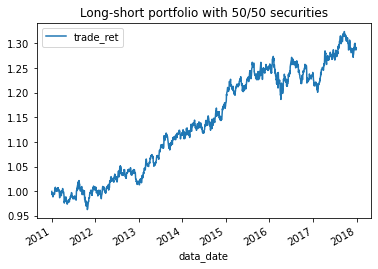

In [37]:
rf_simulation(50,pred_merge)

                           trade_ret
Annual Return %                27.94
Sharpe Ratio                    1.31
Sortino                         0.11
Omega                           1.24
Volatility %                   21.28
semi-variance %                 0.94
VaR(30days) %                 -10.08
Max drawdwon %                 29.86
return/Max drawdwon             0.94
positive rate %                71.43
1 year return (rolling) %      30.59
3 year return (rolling) %     117.14
5 year return (rolling) %     256.34
1 year rolling VaR(5%) %       -3.13


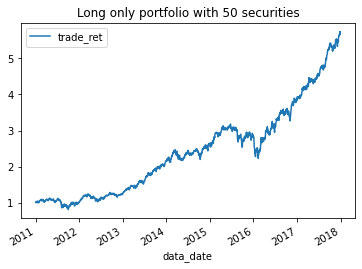

In [38]:
rf_simulation(50,pred_merge,long_only=True)

                           trade_ret
Annual Return %               -20.00
Sharpe Ratio                   -0.82
Sortino                        -0.07
Omega                           0.87
Volatility %                   24.33
semi-variance %                 1.09
VaR(30days) %                 -11.23
Max drawdwon %                 82.27
return/Max drawdwon            -0.24
positive rate %                40.48
1 year return (rolling) %     -18.95
3 year return (rolling) %     -45.79
5 year return (rolling) %     -64.47
1 year rolling VaR(5%) %      -34.58


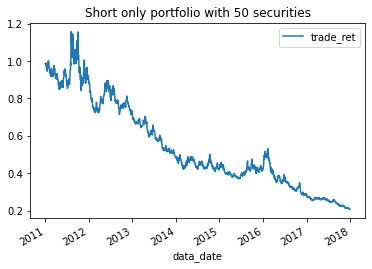

In [39]:
rf_simulation(50,pred_merge,short_only=True)

#### Convert the predicted return to the ranking percentile within previous 250 days and compared the performance

In [40]:
sec_dic = {}
sec_lst = pred_merge['security_id'].unique()
for sec in tqdm(sec_lst):
    df = pred_merge[pred_merge['security_id'] == sec]
    #convert to ranking percentile
    df['ret_rank'] = df['pred_ret'].rolling(250).rank(pct=True,method = 'min')
    sec_dic[sec] = df

100%|██████████████████████████████████████████████████████████████████████████████| 6310/6310 [02:36<00:00, 40.30it/s]


In [41]:
rank_merge =  pd.concat(sec_dic.values(),axis = 0)

In [65]:
def rank_rf(num_sec):
    Y_rank_sec = rank_merge[rank_merge['in_trading_universe'] == 'Y']
    Y_rank_sec = Y_rank_sec.drop('index',axis = 1)
    Y_rank_sec = Y_rank_sec.dropna(subset=['ret_rank'])
    Y_rank_sec = Y_rank_sec.sort_index()
    Y_rank_sec['rank'] = Y_rank_sec.groupby('data_date')['ret_rank'].rank()
    Y_rank_sec['num_sec'] = Y_rank_sec.groupby('data_date').size()
    Y_rank_sec['Signal'] = np.where(Y_rank_sec['rank'] < num_sec,1,
                                    np.where(Y_rank_sec['rank'] > Y_rank_sec['num_sec'] - num_sec,-1,0))
    Y_rank_sec['trade_ret'] = Y_rank_sec['Signal'] *  Y_rank_sec['ret1d']
    Y_rank_sec['trade_ret'] = Y_rank_sec['Signal'] *  Y_rank_sec['ret1d']
    (1+Y_rank_sec.groupby('data_date')[['trade_ret']].sum()/(2*num_sec)).cumprod().plot(title ='long-short')
    print(perform_statistics(Y_rank_sec.groupby('data_date')[['trade_ret']].sum()/(2*num_sec)))

                           trade_ret
Annual Return %                -0.28
Sharpe Ratio                   -0.07
Sortino                        -0.00
Omega                           0.99
Volatility %                    3.97
semi-variance %                 0.18
VaR(30days) %                  -1.80
Max drawdwon %                  7.95
return/Max drawdwon            -0.04
positive rate %                45.21
1 year return (rolling) %       0.05
3 year return (rolling) %       1.16
5 year return (rolling) %       0.18
1 year rolling VaR(5%) %       -4.30


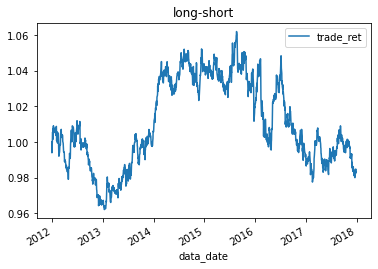

In [67]:
rank_rf(50)

#### OLS performance analysis (all data)

In [322]:
ols_pd = merge_pd.fillna(0)

In [323]:
sec_lst = ols_pd['security_id'].unique()
r_s = []
for sec in sec_lst:
    tmp = ols_pd[ols_pd['security_id'] == sec]
    X = tmp.iloc[:,7:]
    y =  tmp['ret1d']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    r_s.append((sec,model.rsquared))

In [324]:
sorted_pairs = sorted(r_s, key=lambda x: x[1],reverse = True)

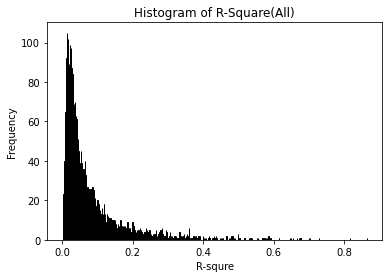

In [326]:
second_value = [item[1] for item in sorted_pairs]
plt.hist(second_value, bins=1000, edgecolor='k')
plt.xlabel('R-squre')
plt.ylabel('Frequency')
plt.title('Histogram of R-Square(All)')
plt.show()

#### OLS with those securities that have more than 250 days data

In [327]:
filter_pd = ols_pd.groupby('security_id').filter(lambda group: len(group) > 250)

In [329]:
sec_lst = filter_pd['security_id'].unique()
r_s = []
for sec in sec_lst:
    tmp = filter_pd[filter_pd['security_id'] == sec]
    X = tmp.iloc[:,-17:]
    y =  tmp['ret1d']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    r_s.append((sec,model.rsquared))

In [330]:
sorted_pairs = sorted(r_s, key=lambda x: x[1],reverse = True)

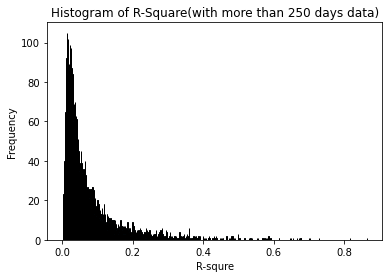

In [332]:
second_values = [item[1] for item in sorted_pairs]
plt.hist(second_values, bins=1000, edgecolor='k')
plt.xlabel('R-squre')
plt.ylabel('Frequency')
plt.title('Histogram of R-Square(with more than 250 days data)')
plt.show()

#### Multi-factor model regarding to 6 risk factors

In [68]:
risk_factors = pred_merge[['security_id','volume','close_price','ret1d','rf1','rf2','rf3','rf4','rf5','rf6']]

In [71]:
sec_dic = {}
sec_lst = merge_pd['security_id'].unique()
for sec in tqdm (sec_lst):
    df = merge_pd[merge_pd['security_id'] == sec]
    # only create factor on 6 six risk factors
    df = df[['data_date','security_id','volume','close_price','ret1d','rf1','rf2','rf3','rf4','rf5','rf6']]
    features = df.columns[-6:]
    df[features] = df[features].diff().shift(2)
    for feature in features:
        # get the overall mean and standard deviation
        df[feature + ' mean'] = df[feature].mean()
        df[feature + ' std'] = df[feature].std()
    df =df.iloc[3:]
    sec_dic[sec] = df 

100%|██████████████████████████████████████████████████████████████████████████████| 6321/6321 [01:16<00:00, 82.10it/s]


In [72]:
# risk_merge is the dataframe that use mean and standard deviation to generate the trading signal
risk_merge =  pd.concat(sec_dic.values(),axis = 0)

In [73]:
risk_merge['data_date'] = pd.to_datetime(risk_merge['data_date'], format='%Y%m%d')

In [74]:
risk_merge = risk_merge.set_index('data_date')
risk_merge = risk_merge.sort_index()

In [171]:
risk_merge.corr()

,security_id,volume,close_price,ret1d,rf1,rf2,rf3,rf4,rf5,rf6,...,rf2 mean,rf2 std,rf3 mean,rf3 std,rf4 mean,rf4 std,rf5 mean,rf5 std,rf6 mean,rf6 std
security_id,1.000000,-0.033568,-0.061478,-0.001399,-0.000387,-0.000805,0.001398,0.002416,-0.000468,-0.001444,...,-0.069620,0.215557,0.205932,0.067825,0.131836,0.300658,-0.030909,0.344712,-0.074845,0.111163
volume,-0.033568,1.000000,0.010466,0.012415,0.000038,0.000098,0.003126,0.000236,-0.000389,0.001693,...,-0.003843,-0.089628,0.014263,-0.088636,0.005926,-0.055845,0.000510,-0.011723,0.029391,-0.047430
close_price,-0.061478,0.010466,1.000000,0.004502,0.000264,0.000892,0.000095,-0.001626,0.000760,0.000289,...,0.006433,-0.311960,0.020175,-0.190050,-0.031804,-0.265766,0.027002,-0.161839,0.016895,-0.260729
ret1d,-0.001399,0.012415,0.004502,1.000000,-0.002250,-0.001387,-0.000315,0.003304,0.000818,0.001211,...,0.012196,0.008048,-0.005733,-0.002952,-0.009270,-0.000189,0.003100,-0.000614,0.004677,0.001352
rf1,-0.000387,0.000038,0.000264,-0.002250,1.000000,0.001961,-0.136297,0.004479,0.000455,0.003944,...,0.000173,0.000363,-0.002204,-0.000763,-0.000616,-0.000967,0.000342,-0.000520,-0.000328,-0.000942
rf2,-0.000805,0.000098,0.000892,-0.001387,0.001961,1.000000,-0.000315,-0.004211,0.000181,0.002017,...,0.011561,-0.000734,-0.002163,0.000664,-0.004544,-0.001110,0.000786,-0.001136,0.001962,-0.000611
rf3,0.001398,0.003126,0.000095,-0.000315,-0.136297,-0.000315,1.000000,-0.018042,0.000499,-0.003455,...,-0.001270,0.000401,0.006787,0.000083,0.001181,0.000856,-0.000608,0.000688,-0.001738,-0.000016
rf4,0.002416,0.000236,-0.001626,0.003304,0.004479,-0.004211,-0.018042,1.000000,0.020174,0.168690,...,-0.007204,0.001003,0.003189,0.000014,0.018329,0.001423,-0.000686,0.002115,0.000758,0.001382
rf5,-0.000468,-0.000389,0.000760,0.000818,0.000455,0.000181,0.000499,0.020174,1.000000,0.039055,...,0.001030,-0.001669,-0.001356,0.000215,-0.000567,-0.001873,0.015138,-0.000536,0.003420,-0.001194
rf6,-0.001444,0.001693,0.000289,0.001211,0.003944,0.002017,-0.003455,0.168690,0.039055,1.000000,...,0.003276,-0.001813,-0.004943,0.000303,0.000798,-0.001781,0.004360,-0.001282,0.019299,-0.000674


#### Based on the correlation matrix r1,r2,r3 are negative correlated with next period return while r4,r5,r6 are postive correlated

In [79]:
sec_dic = {}
sec_lst = merge_pd['security_id'].unique()
for sec in tqdm (sec_lst):
    df = merge_pd[merge_pd['security_id'] == sec]
    df = df[['data_date','security_id','volume','close_price','ret1d','rf1','rf2','rf3','rf4','rf5','rf6']]
    features = df.columns[-6:]
    df[features] = df[features].rolling(250).rank(pct=True,method = 'min').shift(2)
    df =df.dropna(subset = ['rf1'])
    sec_dic[sec] = df 

100%|██████████████████████████████████████████████████████████████████████████████| 6321/6321 [01:24<00:00, 75.11it/s]


In [80]:
# risk_merge is the dataframe that use ranking percentile in previous 250 days to generate the sinals.
risk_rank_merge =  pd.concat(sec_dic.values(),axis = 0)

In [81]:
risk_rank_merge['data_date'] = pd.to_datetime(risk_rank_merge['data_date'], format='%Y%m%d')
risk_rank_merge = risk_rank_merge.set_index('data_date')
risk_rank_merge = risk_rank_merge.sort_index()

In [94]:
# transaction cost calculated
def transaction_cost(risk,rate):
    sec_dic = {}
    sec_list = risk['security_id'].unique()
    for sec in sec_list:
        df = risk[risk['security_id'] == sec]
        #get the cumulative sum of the difference of the weights of each securities
        df['tran_cost'] = abs(df['weights'].diff()).cumsum() * rate
        sec_dic[sec] = df 
    merge_pd =  pd.concat(sec_dic.values(),axis = 0)
    merge_pd = merge_pd.sort_index()
    return merge_pd

In [113]:
# factor name 'rf1','rf2'.....,'rf6'; rank is using ranking percentile or not; positive_cor is the correlation of factor and ret
def risk_factors_simulation(factor_name, rank = False,positive_cor = False):
    indicator = 1 if positive_cor else -1
    
    if rank:
        risk_factor = risk_rank_merge[['security_id','volume','close_price','ret1d',factor_name]]
        risk_factor['signal'] = np.where(risk_factor[factor_name] > 0.75,indicator,
                                         np.where(risk_factor[factor_name] < 0.25,-1*indicator,0))
        title_ = 'Ranked ' + factor_name
    else:
        risk_factor = risk_merge[['security_id','volume','close_price','ret1d',factor_name,factor_name+' mean',factor_name+' std']]
        risk_factor['signal'] = np.where(risk_factor[factor_name] > risk_factor[factor_name+' mean']+risk_factor[factor_name+ ' std'],indicator,
                                         np.where(risk_factor[factor_name] < risk_factor[factor_name+' mean']-risk_factor[factor_name+' std'],-1*indicator,0))
        title_ = 'Non-ranked ' + factor_name
    risk_factor['trade_ret'] = risk_factor['signal'] * risk_factor['ret1d']
    #number of long securities and short securities
    risk_factor['long_num'] = risk_factor.groupby('data_date')['signal'].apply(lambda x: (x == 1).sum())
    risk_factor['short_num'] = risk_factor.groupby('data_date')['signal'].apply(lambda x: (x == -1).sum())
    risk_factor['daily_ret'] = risk_factor.groupby('data_date')['trade_ret'].sum()/(risk_factor['long_num']+risk_factor['short_num'])
    #get the weights for calculating the transaction cost
    risk_factor['weights'] = np.where(risk_factor['signal'] == 1,1/risk_factor['long_num'],
                                                                       np.where(risk_factor['signal'] == -1,-1/risk_factor['short_num'],0))
    risk_factor = transaction_cost(risk_factor,0.0001)
    risk_factor['daily_ret'] =risk_factor['daily_ret'] -risk_factor['tran_cost']
    (1+risk_factor.groupby('data_date')[['daily_ret']].mean()).cumprod().plot(title = title_)
    return risk_factor.groupby('data_date')[['daily_ret']].mean()

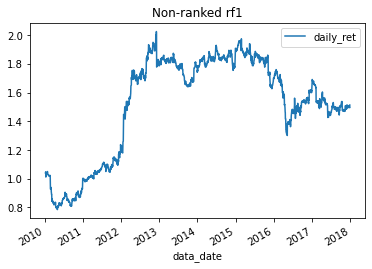

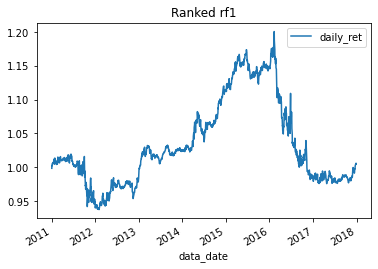

In [114]:
risk1_nrank = risk_factors_simulation('rf1',False,False)
risk1_rank = risk_factors_simulation('rf1',True,False)

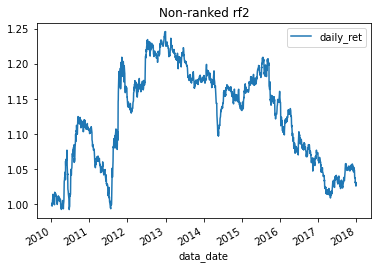

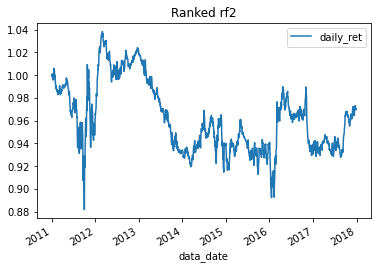

In [115]:
risk2_nrank =risk_factors_simulation('rf2',False,False)
risk2_rank =risk_factors_simulation('rf2',True,False)

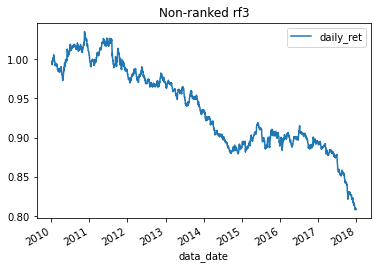

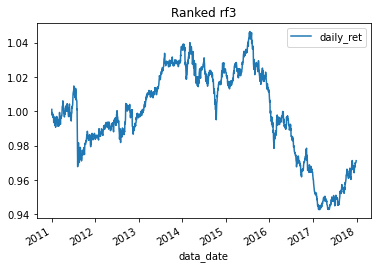

In [173]:
risk3_nrank =risk_factors_simulation('rf3',False,False)
risk3_rank =risk_factors_simulation('rf3',True,False)

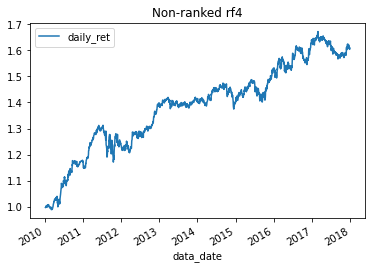

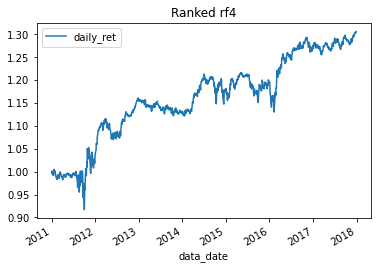

In [117]:
risk4_nrank =risk_factors_simulation('rf4',False,True)
risk4_rank =risk_factors_simulation('rf4',True,True)

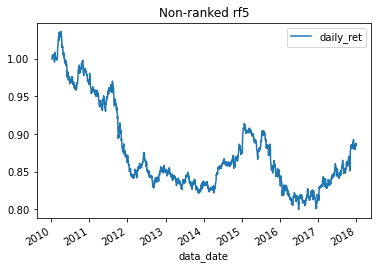

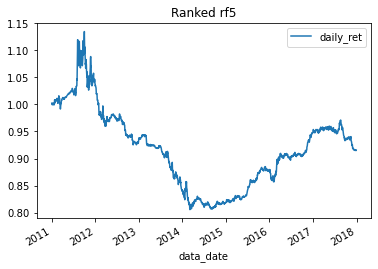

In [175]:
risk5_nrank =risk_factors_simulation('rf5',False,True)
risk5_rank =risk_factors_simulation('rf5',True,True)

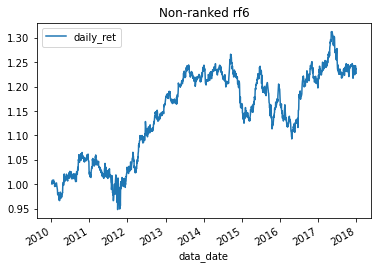

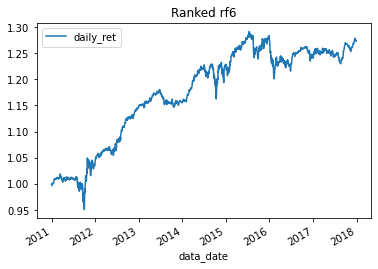

In [174]:
risk6_nrank =risk_factors_simulation('rf6',False,True)
risk6_rank =risk_factors_simulation('rf6',True,True)

In [196]:
risk_factors_ret = pd.concat([risk1_rank,risk1_nrank,
                              risk2_rank,risk2_nrank,
                              risk3_rank,risk3_nrank,
                              risk4_rank,risk4_nrank,
                              risk5_rank,risk5_nrank,
                              risk6_rank,risk6_nrank],axis = 1)
risk_factors_ret.columns = ['risk1 rank','risk1 no rank',
                            'risk2 rank','risk2 no rank',
                            'risk3 rank','risk3 no rank',
                            'risk4 rank','risk4 no rank',
                            'risk5 rank','risk5 no rank',
                            'risk6 rank','risk6 no rank']

In [197]:
risk_factors_ret.corr()

,risk1 rank,risk1 no rank,risk2 rank,risk2 no rank,risk3 rank,risk3 no rank,risk4 rank,risk4 no rank,risk5 rank,risk5 no rank,risk6 rank,risk6 no rank
risk1 rank,1.000000,0.048058,-0.398492,-0.002493,-0.283056,0.068991,-0.443790,-0.024471,0.325407,0.023614,-0.321745,-0.043194
risk1 no rank,0.048058,1.000000,0.011159,0.006244,0.000457,-0.106754,-0.015969,-0.088603,0.037818,0.010983,0.010641,-0.043336
risk2 rank,-0.398492,0.011159,1.000000,0.085705,0.246213,-0.057749,0.873023,0.084088,-0.433556,-0.068312,0.704610,0.049906
risk2 no rank,-0.002493,0.006244,0.085705,1.000000,-0.041477,-0.005939,0.053267,0.004425,0.044586,-0.051920,0.047241,0.057450
risk3 rank,-0.283056,0.000457,0.246213,-0.041477,1.000000,0.019462,0.295468,0.052786,-0.309822,-0.046082,0.353398,0.027998
risk3 no rank,0.068991,-0.106754,-0.057749,-0.005939,0.019462,1.000000,-0.080726,0.053985,0.045132,0.020363,-0.050322,-0.027451
risk4 rank,-0.443790,-0.015969,0.873023,0.053267,0.295468,-0.080726,1.000000,0.180706,-0.506843,-0.079281,0.800253,0.118550
risk4 no rank,-0.024471,-0.088603,0.084088,0.004425,0.052786,0.053985,0.180706,1.000000,-0.143144,-0.058147,0.135344,0.474964
risk5 rank,0.325407,0.037818,-0.433556,0.044586,-0.309822,0.045132,-0.506843,-0.143144,1.000000,0.038579,-0.350334,-0.103955
risk5 no rank,0.023614,0.010983,-0.068312,-0.051920,-0.046082,0.020363,-0.079281,-0.058147,0.038579,1.000000,-0.056888,-0.043003


In [198]:
#input: the daily return of different factors
def compute_tangency(df_tilde):
    
    #Compute tangency portfolio given a set of excess returns.
    Sigma = df_tilde.cov()
    N = Sigma.shape[0]
    Sigma_adj = Sigma.copy()
    mu_tilde = df_tilde.mean()
    Sigma_inv = np.linalg.inv(Sigma_adj)
    weights = Sigma_inv @ mu_tilde / (np.ones(N) @ Sigma_inv @ mu_tilde)
    omega_tangency = pd.Series(weights, index=mu_tilde.index)
    return -omega_tangency, mu_tilde, Sigma_adj


omega_tangency, mu_tilde, Sigma = compute_tangency(risk_factors_ret)

omega_tangency.to_frame('Tangency Weights')

,Tangency Weights
risk1 rank,0.262839
risk1 no rank,0.202006
risk2 rank,-3.016596
risk2 no rank,0.136486
risk3 rank,-1.265950
risk3 no rank,-1.887674
risk4 rank,2.539639
risk4 no rank,0.875946
risk5 rank,0.054643
risk5 no rank,-0.322421


<AxesSubplot:xlabel='data_date'>

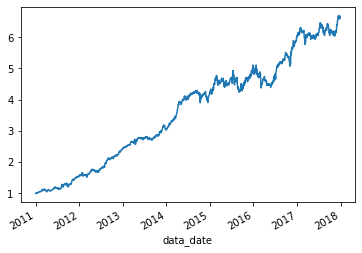

In [200]:
(1+risk_factors_ret@omega_tangency).cumprod().plot()

In [209]:
#risk_factors_ret@omega_tangency: portfolio return
perform_statistics(risk_factors_ret@omega_tangency.to_frame())

,0
Annual Return %,30.92
Sharpe Ratio,2.11
Sortino,0.19
Omega,1.40
Volatility %,14.68
semi-variance %,0.60
VaR(30days) %,-6.48
Max drawdwon %,14.38
return/Max drawdwon,2.15
positive rate %,71.43


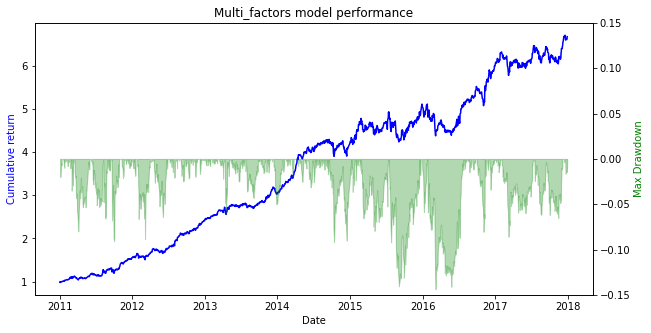

In [207]:
tmp = (1+risk_factors_ret@omega_tangency.to_frame()).cumprod()
tmp.columns = ['Cumulative return']
tmp['Max Drawdown'] = tmp['Cumulative return']/tmp['Cumulative return'].cummax()-1
fig, ax1 = plt.subplots(figsize = (10,5))

# Plot column1 as line chart
ax1.plot(tmp.index, tmp['Cumulative return'], color='blue')
ax1.set_ylabel('Cumulative return', color='blue')

# Create second y-axis
ax2 = ax1.twinx()

# Plot column2 as area graph
ax2.fill_between(tmp.index, tmp['Max Drawdown'], color='green', alpha=0.3)
ax2.set_ylabel('Max Drawdown', color='green')
ax2.set_ylim([-0.15,0.15])
# Customize plot
ax1.set_xlabel('Date')
ax1.set_title('Multi_factors model performance')

# Show the plot
plt.show()